In [36]:
# Read in data from spreadsheet at ./data/variables.xlsx
import pandas as pd
def readVars(sheet, skiprows, nrows):
    data = pd.read_excel('./data/variables.xlsx', sheet_name=sheet, skiprows = skiprows, nrows = nrows)
    # Variable 	Value	Unit	Description	Finalized
    data.columns = ['Variable', 'Value', 'Unit', 'Description', 'Finalized']
    for i in range(len(data)):
        exec('global ' + data['Variable'][i] + '; ' + data['Variable'][i] + ' = ' + str(data['Value'][i]))
        print(data['Variable'][i] + ' = ' + str(data['Value'][i]))

In [37]:
# STRUCTURES
readVars("STRUCTURES", 1, 6) # General
readVars("STRUCTURES", 8, 4) # Tanks
readVars("STRUCTURES", 13, 2) # Nosecone
readVars("STRUCTURES", 16, 5) # Fins
readVars("STRUCTURES", 22, 3) # Buttons

vehicle_mass_dry = 79
vehicle_COM_dry_no_engine = 68
vehicle_diameter = 6
vehicle_height = 151
rail_length = 20
launch_angle = 5
tank_height_ox = 34.5
tank_height_fuel = 10.3
tank_position_ox = 71.0
tank_position_fuel = 35.0
nosecone_height = 24
nosecone_kind = "ogive"
fin_number = 4.0
fin_root_chord = 9.0
fin_tip_chord = 2.5
fin_span = 5.5
fin_position = 14.0
button_position_higher = 75.5
button_position_lower = 15.100000000000001
button_angle = 45.0


In [38]:
# PROPULSION
readVars("PROPULSION", 1, 7) # General

engine_thrust_initial = 1000.0
ox_flow_initial = 3.62
fuel_flow_initial = 0.721
engine_mass = 17.12
engine_COM_dry = 9.247
engine_diameter_nozzle = 3.02
engine_position_nozzle = 0.0


In [39]:
# FLUIDS
readVars("FLUIDS", 1, 4) # General

ox_mass_liq = 18.06
ox_mass_vap = 0.0
fuel_mass_liq = 3.52
fuel_mass_vap = 0.0


In [40]:
# RECOVERY
readVars("RECOVERY", 1, 14) # recovery
readVars("RECOVERY", 16, 2) # shear screw characteristics
readVars("RECOVERY", 19, 1) # U-bolt
readVars("RECOVERY", 21, 2) # flight characteristics
readVars("RECOVERY", 24, 5) # parachute inputs
readVars("RECOVERY", 30, 5) # volumetric inputs
readVars("RECOVERY", 36, 2) # black powder inputs

recovery_Cd = 0.97
recovery_diameter_drogue = 48.0
recovery_diameter_main = 108.0
recovery_height_trigger_main = 2000.0
FOS = 2.0
dryMass = 0.0
upperDragDrogue = 0.138
lowerDragDrogue = 0.85
upperMassDrogue = 0.491
lowerMassDrogue = 2.306
upperDragMain = 0.138
lowerDragMain = 0.85
upperMassMain = 0.3668
lowerMassMain = 2.431
minScrewStreingth = 33.1
maxScrewStrength = 57.1
uboltStrength = 2000
timeDrogueDeploy = 0
timeMainDeploy = 0
drogueCd = 0.97
recovery_diamter_drogue = 48.0
mainCd = 0.97
recovery_diameter_main = 108.0
airDensity = 0.0765
vehicle_diameter = 7.0
avionicsOverlap = 5.0
uboltLength = 1.5
packingVolDrogue = 18.58
packingVolMain = 94.25
gasConstant = 266
combustTemp = 3307


In [41]:
# Input Parameters
from rocketpy import Fluid
# CONVERT FUNCTION
# from UnitConversion import unit_conversion

#SOLVER: General
thrust_decay = 1
discrete_segments = 100

#FLUIDS
ox_liq = Fluid(name="N2O_l", density=786.25)
ox_gas = Fluid(name="N2O_g", density=157.19) 
fuel_liq = Fluid(name="ethane_l", density=339.66) 
fuel_gas = Fluid(name="ethane_g", density=85.7) 

# Main Test

<H1> ENVIRONMENTAL INFORMATION</H1>

- Solves for environmental information today at a random location

In [42]:
#Environmental Information

from rocketpy import Environment, Flight

env = Environment(latitude=32.990254, longitude=-106.974998, elevation=1400)


import datetime
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date(
    (tomorrow.year, tomorrow.month, tomorrow.day, 12)
) #Hour given in UTC time

env.set_atmospheric_model(type="Forecast", file="GFS")

<h1> SOLVER RUN </h1>

- Creates all object files and runs flight simulation

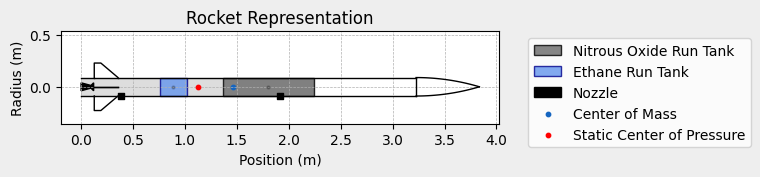

In [43]:
from rocketpy import CylindricalTank, Fluid, MassBasedTank, MassFlowRateBasedTank, LiquidMotor, Rocket, Flight
import numpy as np

#UNIT CONVERSION
# CONVERSION UNITS
in2m = 0.0254
ft2m = 0.305
lb2kg = 0.454
lbf2N = 4.45

#SOLVER: General
thrust_decay_metric = thrust_decay
discrete_segments_metric = discrete_segments

# STRUCTURES: General
vehicle_mass_dry_metric = vehicle_mass_dry * lb2kg #kg (does not include engine)
vehicle_COM_dry_no_engine_metric = vehicle_COM_dry_no_engine * in2m #m
vehicle_diameter_metric = vehicle_diameter * in2m #m
vehicle_height_metric = vehicle_height * in2m #m
rail_length_metric = rail_length * ft2m #m
launch_angle_metric = launch_angle

# STRUCTURES: Tanks
tank_height_ox_metric = tank_height_ox * in2m #m
tank_height_fuel_metric = tank_height_fuel * in2m #m
tank_position_ox_metric = tank_position_ox * in2m #m (geometric center of tank)
tank_position_fuel_metric = tank_position_fuel * in2m #m (geometric center of tank)

# STRUCTURES: Nosecone
nosecone_height_metric = nosecone_height * in2m #m
nosecone_kind_metric = nosecone_kind


# STRUCTURES: Fins
fin_number_metric = int(fin_number)
fin_root_chord_metric = fin_root_chord * in2m #m
fin_tip_chord_metric = fin_tip_chord * in2m #m
fin_span_metric = fin_span * in2m #m 
fin_position_metric = fin_position * in2m #m (position is the top part of where fin starts)


# STRUCTURES: Buttons
button_position_higher_metric = button_position_higher * in2m #m
button_position_lower_metric = button_position_lower * in2m #m
button_angle_metric = button_angle

# STRUCTURES: Recovery
recovery_Cd_metric = recovery_Cd
recovery_diameter_drogue_metric = recovery_diameter_drogue * in2m #m
recovery_diameter_main_metric = recovery_diameter_main * in2m #m
recovery_height_trigger_main = recovery_height_trigger_main * ft2m #m

#FLUIDS
ox_liq_metric = ox_liq
ox_gas_metric = ox_gas
fuel_liq_metric = fuel_liq
fuel_gas_metric = fuel_gas
ox_mass_liq_metric = ox_mass_liq * lb2kg #kg
ox_mass_vap_metric = ox_mass_vap * lb2kg #kg
fuel_mass_liq_metric = fuel_mass_liq * lb2kg #kg
fuel_mass_vap_metric = fuel_mass_vap * lb2kg #kg

# PROPULSION
engine_thrust_initial_metric = engine_thrust_initial * lbf2N #N
ox_flow_initial_metric = ox_flow_initial * lb2kg #kg/s
fuel_flow_initial_metric = fuel_flow_initial * lb2kg #kg/s
engine_mass_metric = engine_mass * lb2kg #kg
engine_COM_dry_metric = engine_COM_dry * in2m #m
engine_diameter_nozzle_metric = engine_diameter_nozzle * in2m #m
engine_position_nozzle_metric = engine_position_nozzle * in2m #m (we define everything from the nozzle exit)


#CREATE MASS & THRUST CSVs
np.set_printoptions(suppress=True, precision=8)
ox_mass_total_metric = ox_mass_liq_metric + ox_mass_vap_metric
fuel_mass_total_metric = fuel_mass_liq_metric + fuel_mass_vap_metric
time_ox_metric = ox_mass_liq_metric / ox_flow_initial_metric
time_fuel_metric = fuel_mass_liq_metric / fuel_flow_initial_metric
timeRun_metric = min(time_ox_metric, time_fuel_metric)
if ((time_ox_metric - time_fuel_metric)/time_ox_metric) > 0.10:
    print("Over 10% deviation in time")
timeRun_array_metric = np.linspace(0, timeRun_metric, discrete_segments_metric)
ox_mass_liq_remaining_metric = ox_mass_liq_metric - (timeRun_metric * ox_flow_initial_metric) #Remaining ox after time
fuel_mass_liq_remaining_metric = fuel_mass_liq_metric - (timeRun_metric * fuel_flow_initial_metric) #Remaining fuel after time
ox_mass_change_metric = np.linspace(ox_mass_total_metric, ox_mass_vap_metric + ox_mass_liq_remaining_metric, discrete_segments_metric)
fuel_mass_change_metric = np.linspace(fuel_mass_total_metric, fuel_mass_vap_metric + fuel_mass_liq_remaining_metric, discrete_segments_metric)
engine_thrust_metric = np.linspace(engine_thrust_initial_metric, thrust_decay_metric * engine_thrust_initial_metric, discrete_segments_metric)
timeRun_array_metric = np.linspace(0, timeRun_metric, discrete_segments_metric)
ox_mass_matrix_metric = np.column_stack((timeRun_array_metric, ox_mass_change_metric))
fuel_mass_matrix_metric = np.column_stack((timeRun_array_metric, fuel_mass_change_metric))
engine_thrust_matrix_metric = np.column_stack((timeRun_array_metric, engine_thrust_metric))
np.savetxt("data/ox_mass.csv", ox_mass_matrix_metric, delimiter=",", comments='')
np.savetxt("data/fuel_mass.csv", fuel_mass_matrix_metric, delimiter=",",comments='')
np.savetxt("data/engine_thrust.csv", engine_thrust_matrix_metric, delimiter=",",comments='')

#GEOMETRY OF TANKS
oxTankGeometry = CylindricalTank(vehicle_diameter_metric/2, tank_height_ox_metric, spherical_caps=False)
fuelTankGeometry = CylindricalTank(vehicle_diameter_metric/2, tank_height_fuel_metric, spherical_caps=False)


oxTank = MassBasedTank(
    name = "Nitrous Oxide Run Tank",
    geometry = oxTankGeometry,
    liquid = ox_liq_metric,
    gas = ox_gas_metric,
    liquid_mass = "./data/ox_mass.csv",
    gas_mass = ox_mass_vap_metric,
    flux_time = timeRun_metric
)

fuelTank = MassBasedTank(
    name = "Ethane Run Tank",
    geometry = fuelTankGeometry,
    liquid = fuel_liq_metric,
    gas = fuel_gas_metric,
    liquid_mass = "./data/fuel_mass.csv",
    gas_mass = fuel_mass_vap_metric,
    flux_time = timeRun_metric
)

theEngine = LiquidMotor(  
    thrust_source = "./Yengine.eng",
    dry_mass = engine_mass_metric,
    dry_inertia = (0.125, 0.125, 0.002), #dumb values
    nozzle_radius = engine_diameter_nozzle_metric/2,
    center_of_dry_mass_position = engine_COM_dry_metric, 
    nozzle_position = engine_position_nozzle_metric,
    burn_time = timeRun_metric,
    coordinate_system_orientation = "nozzle_to_combustion_chamber"
)
theEngine.add_tank(tank=oxTank, position = tank_position_ox_metric)
theEngine.add_tank(tank=fuelTank, position = tank_position_fuel_metric)

theRocket = Rocket(
    radius = vehicle_diameter_metric/2,
    mass = vehicle_mass_dry_metric,
    center_of_mass_without_motor = vehicle_COM_dry_no_engine_metric,
    inertia = (6.321, 6.321, 0.034), #dumb values
    power_off_drag = "./data/dragCurve.csv",
    power_on_drag = "./data/dragCurve.csv",
    coordinate_system_orientation = "tail_to_nose"
)
theRocket.add_motor(
    motor = theEngine,
    position = engine_position_nozzle_metric
)

nose_cone = theRocket.add_nose(
    length=nosecone_height_metric,
    kind=nosecone_kind_metric,
    position=vehicle_height_metric)
fin_set = theRocket.add_trapezoidal_fins(
    n=fin_number_metric,
    root_chord=fin_root_chord_metric,
    tip_chord=fin_tip_chord_metric,
    span=fin_span_metric,
    position=fin_position_metric)
railButtons = theRocket.set_rail_buttons(
    upper_button_position=button_position_higher_metric,
    lower_button_position=button_position_lower_metric,
    angular_position=button_angle_metric)

#Rest parachutes list (issues with .append adding duplicates)
if theRocket.parachutes:
    theRocket.parachutes.clear()
drogue = theRocket.add_parachute(
    name="Drogue",
    cd_s=recovery_Cd_metric * (np.pi/4) * recovery_diameter_drogue_metric**2,
    trigger="apogee",
    sampling_rate=105,
    lag=0, 
)

main = theRocket.add_parachute(
    name="Main",
    cd_s=recovery_Cd_metric * (np.pi/4) * recovery_diameter_main_metric**2,
    trigger=recovery_height_trigger_main,
    sampling_rate=105,
    lag=0,
)
test_flight = Flight(
    rocket=theRocket, environment=env, rail_length=rail_length_metric, inclination=90-launch_angle_metric, heading=0
) 

from rocketpy import rocket
theRocket.draw()

<h1> OUTPUT: NUMERICAL VALUES

In [44]:

import numpy as np

#DATA OUTPUT
dryMass = theRocket.mass + theEngine.dry_mass

#Solving Static_margin
timeSteps = np.linspace(0, timeRun_metric, 100)
staticMarginOutputs = theRocket.static_margin(timeSteps)
maxStaticMargin = max(staticMarginOutputs)
minStaticMargin = min(staticMarginOutputs)

#Solving Average Thrust on Rail
timeRail = np.linspace(0, test_flight.out_of_rail_time, 100)
outputThrustOutputs = theEngine.thrust(timeRail)
outputRailMass = theRocket.total_mass(timeRail)
averageRailThrust = np.mean(outputThrustOutputs)
averageRailWeight = (np.mean(outputRailMass) * 9.81) #Keep in metric since thrust in newtons

#print(outputThrustOutputs)

#Seconds of each event
timeDrogueDeploy = (test_flight.parachute_events[0][0])
timeMainDeploy = (test_flight.parachute_events[1][0])
timeImpact = (test_flight.t_final)
timeFlameout = timeRun_metric

#Solving Average Drogue Descent Speed
elements = 100
timeDrogue = np.linspace(timeDrogueDeploy, timeMainDeploy, elements)
outputDrogueDescentSpeed = (test_flight.vz(timeDrogue)) / (in2m * 12) #Convert to ft/s
averageDrogueDescentSpeed = np.average(outputDrogueDescentSpeed)
maxDrogueDescentSpeed = min(outputDrogueDescentSpeed) #min() called since we are dealing with negative floats
minDrogueDescentSpeed = max(outputDrogueDescentSpeed[5:elements-5]) #ignore first 5 elements

#Solving altitude main descent velocity brought under 30 ft/s
timeMain = np.linspace(timeMainDeploy, timeImpact, 100)
timeMainThreshold = False #Initializing to default if trigger never reached. This will describe the time the vehicle descent speed is below 30ft/s
#index all except last value just in case impact has weird effect
for t in timeMain[:-1]:
    descentSpeedImperial = test_flight.vz(t) / (in2m * 12)
    if descentSpeedImperial < 30:
        timeMainThreshold = t
        break
if timeMainThreshold:
    altitudeMainThreshold = (test_flight.z(timeMainThreshold) - env.elevation)/ (in2m * 12)
else:
    altitudeMainThreshold = "NEVER"
        
#Max Dynamic Pressure

#Output Data I Need
print("INPUTS")
print(f"Rocket Wet Mass: {theRocket.total_mass(0)} kg")
print(f"Rocket Dry Mass with Payload: {dryMass} kg")
print(f"Ox Mass: {oxTank.liquid_mass(0)} kg")
print(f"Fuel Mass: {fuelTank.liquid_mass(0)} kg")
print("")


print("OUTPUTS")
print(f"Apogee: {(test_flight.apogee - env.elevation) / (in2m * 12)} ft")
print(f"Max Q Height / Flameout: {test_flight.z(timeFlameout) / (in2m * 12)} ft")
print(f"Total Impulse: {theEngine.total_impulse} Ns")
print(f"Estimated Burn Time: {theEngine.burn_duration} s")
print(f"Max Static Margin: {(maxStaticMargin)} cal")
print(f"Min Static Margin: {(minStaticMargin)} cal")
print(f"Max Velocity: {(test_flight.max_speed) / (in2m * 12)} ft/s")
print(f"Max Mach: {(test_flight.max_mach_number)}")
print(f"Average Thrust on Rail: {averageRailThrust} N")
print(f"Rail Exit Velocity: {(test_flight.out_of_rail_velocity) / (in2m * 12)} ft/s")
print(f"TTW on Rail: {averageRailThrust / averageRailWeight}")
print(f"Average Drogue Descent from Apogee: {averageDrogueDescentSpeed} ft/s")
print(f"Max Drogue Descent Speed from Apogee: {maxDrogueDescentSpeed} ft/s")
print(f"Min Drogue Descent Speed from Apogee: {minDrogueDescentSpeed} ft/s")
print(f"Altitude where descent < 30 ft/s: {altitudeMainThreshold} ft")
print(f"Ground Hit Velocity: {test_flight.impact_velocity/(in2m * 12)} ft/s")

INPUTS
Rocket Wet Mass: 53.4358 kg
Rocket Dry Mass with Payload: 43.63848 kg
Ox Mass: 8.19924 kg
Fuel Mass: 1.5980800000000002 kg

OUTPUTS
Apogee: 11746.34797819191 ft
Max Q Height / Flameout: 7232.9905118720835 ft
Total Impulse: 16722.336469103055 Ns
Estimated Burn Time: 4.882108183079057 s
Max Static Margin: 1.8642407980565727 cal
Min Static Margin: 1.8109908440183584 cal
Max Velocity: 915.2068600597647 ft/s
Max Mach: 0.8411845532450395
Average Thrust on Rail: 4176.311601318192 N
Rail Exit Velocity: 79.81609809211076 ft/s
TTW on Rail: 8.01863116655578
Average Drogue Descent from Apogee: -94.9887493634991 ft/s
Max Drogue Descent Speed from Apogee: -130.20546485922225 ft/s
Min Drogue Descent Speed from Apogee: -82.41762178408949 ft/s
Altitude where descent < 30 ft/s: 2001.164014223885 ft
Ground Hit Velocity: -38.78062189737503 ft/s


<h1> OUTPUT: STATIC MARGIN </h1>

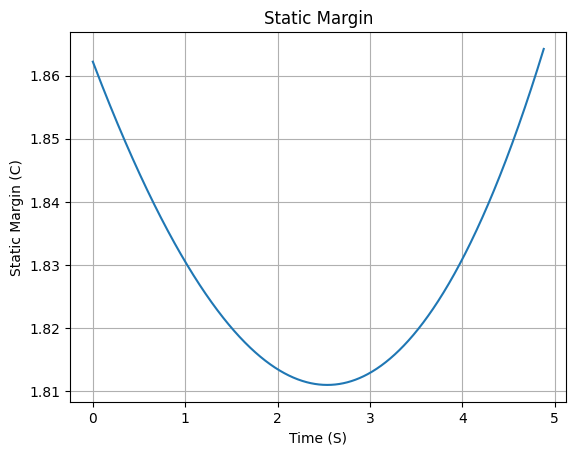

In [45]:
from rocketpy import plots
theRocket.plots.static_margin()

<h1> OUTPUT: TRAJECTORY </h1>

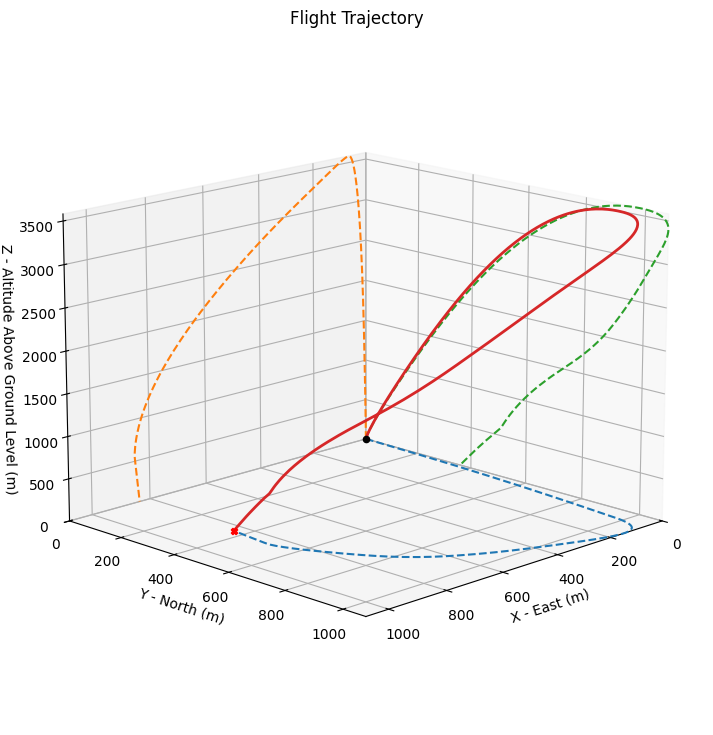

In [46]:
from rocketpy import plots
test_flight.plots.trajectory_3d()

<h1> BENDING MOMENT CALCULATIONS </h1>

In [47]:

#Commenting out for now to audit
"""

#BENDING MOMENT CALCULATIONS
#Collect input variables:
CoP = theRocket.cp_position ((test_flight.max_mach_number)) #[m] from the bottom of the rocket
maxVelocity = (test_flight.max_speed)  #[m]
maxCrosswind = 16 #[m/s], tentatively. rocketpy may have a function for this
angleIronThickness = 0.003175 #[m]
angleIronWidth = 0.0254 #[m]
angleIronHeight = 1.4986 #[m]
angleIronArea = angleIronWidth**2 - (angleIronWidth-angleIronThickness)**2
angleIronAmount = 3 #[]
Cd = 1 #[], tentatively
#vehicle height is stored in heightVehicle, diameter is stored in diameter
tankThickness = .1625 * 0.0254 #[m]
thrustForce = 1000 * 4.44822 #[N]
maxAngle = 0.0872665 #[rad]
tankPressure = 1000 * 6894.76 #[Pa]
rho = 1.225 #[kg/m^3]
rocketDiam = diameter
aluminumModulus = 68*10**9 #[Pa]

#Calculate moments of inertia:
singleAngleIronMoI = (angleIronThickness)*(angleIronWidth)**3 / 3 + (angleIronWidth-angleIronThickness)*(angleIronThickness)**3 / 3 #[m^4]
totalAngleIronMoI = angleIronAmount * (singleAngleIronMoI + angleIronArea*(diameter/2)**2) #[m^4]
aluminumShellMoI = (math.pi / 64) * (rocketDiam**4 - (rocketDiam - 2*tankThickness)**4)#[m^4]
tankCrossSectionalArea = (math.pi / 4) * (rocketDiam**2 - (rocketDiam - 2*tankThickness)**2) #[m^2]

#Calculate the bending moment
totalWind = math.sin(maxAngle) * maxVelocity + maxCrosswind
profileAreaTop = (heightVehicle - CoP) * diameter #[m^2]
profileAreaBottom = CoP * diameter #[m^2]
forceWindTop = 0.5 * profileAreaTop * Cd * rho * totalWind**2 #[N]
forceWindBottom =  0.5 * profileAreaBottom * Cd * rho * totalWind**2 #[N]
forceWindTopDistance = (heightVehicle - CoP) / 2
forceWindBottomDistance = CoP / 2
bendingMoment = forceWindTop * forceWindTopDistance

#Calculating Buckling Load
bucklingConstant = 0.25 # held at bottom, unconstrained at top
aluminumBucklingLoad = bucklingConstant * math.pi**2 * aluminumModulus * aluminumShellMoI / heightVehicle
angleIronBucklingLoad = bucklingConstant * math.pi**2 * aluminumModulus * totalAngleIronMoI / angleIronHeight
singleAngleIronBucklingLoad = bucklingConstant * math.pi**2 * aluminumModulus * singleAngleIronMoI / angleIronHeight
print("Buckling Load of entire vehicle: ", "{:.4f}".format(aluminumBucklingLoad), "N (", "{:.4f}".format(aluminumBucklingLoad*0.2248), "lbs )")
print("Buckling Load of", angleIronAmount, "angle irons: ", "{:.4f}".format(angleIronBucklingLoad), "N (", "{:.4f}".format(angleIronBucklingLoad*0.2248), "lbs )")
print("Buckling Load of single angle iron: ", "{:.4f}".format(singleAngleIronBucklingLoad), "N (", "{:.4f}".format(singleAngleIronBucklingLoad*0.2248), "lbs )")

#Calculating Bending Stresses:
tankBendingStress = bendingMoment * (rocketDiam/2) / aluminumShellMoI
angleIronBendingStress = bendingMoment * (rocketDiam/2 + angleIronWidth/2) / totalAngleIronMoI
print("Maximum bending stress in tank:", "{:.4f}".format(tankBendingStress/10**6), "MPa (", "{:.4f}".format(aluminumBucklingLoad/10**6 * 0.1450377377), "ksi )")
print("Maximum angle iron bending stress:", "{:.4f}".format(angleIronBendingStress/10**6), "MPa (", "{:.4f}".format(angleIronBendingStress/10**6 * 0.1450377377), "ksi )")

#Calculate Pressure Stresses:
p_o = 101352 #[Pa]
p_i = tankPressure #[Pa]
r_i = rocketDiam/2 - tankThickness #[m]
r_o = rocketDiam/2 #[m]
tankLongStress = (p_i*r_i**2 - p_o*r_o**2) / (r_o**2 - r_i**2) 
tankHoopStress = (p_i*r_i**2 - p_o*r_o**2) / (r_o**2 - r_i**2) - r_i**2 * r_o**2 * (p_o - p_i) / (r_o**2 * (r_o**2 - r_i**2))
print("Tank Longitudinal stress in tank:", "{:.4f}".format(tankLongStress/10**6), "MPa (", "{:.4f}".format((tankLongStress/10**6 * 0.1450377377)), "ksi )")
print("Tank Hoop Stress in tank:", "{:.4f}".format(tankHoopStress/10**6), "MPa (", "{:.4f}".format(tankHoopStress/10**6 * 0.1450377377), "ksi )")

# Compile pressure sum:
tankAxialStress = tankBendingStress + tankLongStress - thrustForce / tankCrossSectionalArea
#tankVonMises = math.sqrt(tankAxialStress**2 + tankHoopStress**2 - tankAxialStress*tankHoopStress)
#print("Resultant Von Mises Stress =", "{:.4f}".format(tankVonMises/10**6), "MPa (", "{:.4f}".format(tankVonMises/10**6 * 0.1450377377), "ksi )")

"""

'\n\n#BENDING MOMENT CALCULATIONS\n#Collect input variables:\nCoP = theRocket.cp_position ((test_flight.max_mach_number)) #[m] from the bottom of the rocket\nmaxVelocity = (test_flight.max_speed)  #[m]\nmaxCrosswind = 16 #[m/s], tentatively. rocketpy may have a function for this\nangleIronThickness = 0.003175 #[m]\nangleIronWidth = 0.0254 #[m]\nangleIronHeight = 1.4986 #[m]\nangleIronArea = angleIronWidth**2 - (angleIronWidth-angleIronThickness)**2\nangleIronAmount = 3 #[]\nCd = 1 #[], tentatively\n#vehicle height is stored in heightVehicle, diameter is stored in diameter\ntankThickness = .1625 * 0.0254 #[m]\nthrustForce = 1000 * 4.44822 #[N]\nmaxAngle = 0.0872665 #[rad]\ntankPressure = 1000 * 6894.76 #[Pa]\nrho = 1.225 #[kg/m^3]\nrocketDiam = diameter\naluminumModulus = 68*10**9 #[Pa]\n\n#Calculate moments of inertia:\nsingleAngleIronMoI = (angleIronThickness)*(angleIronWidth)**3 / 3 + (angleIronWidth-angleIronThickness)*(angleIronThickness)**3 / 3 #[m^4]\ntotalAngleIronMoI = angleIro

<h1> FAR-OUT CSV OUTPUT </h1>

In [48]:
# Time: Seconds
# Thrust: Newtons
# Oxidizer Tank Pressure: PSI
# Combustion Chamber Pressure: PSI
# Fuel Tank Pressure: PSI

ox_pressure = 850 #PSI
fuel_pressure = 550 #PSI
chamber_pressure = 400 #PSI

#CREATE MASS & THRUST CSVs
np.set_printoptions(suppress=True, precision=8)
ox_mass_total_metric = ox_mass_liq_metric + ox_mass_vap_metric

ox_pressure_matrix = np.linspace(ox_pressure, ox_pressure, discrete_segments_metric)
fuel_pressure_matrix = np.linspace(fuel_pressure, fuel_pressure, discrete_segments_metric)
chamber_pressure_matrix = np.linspace(chamber_pressure, chamber_pressure, discrete_segments_metric)


FAR_CSV = np.column_stack((timeRun_array_metric, engine_thrust_metric, ox_pressure_matrix, chamber_pressure_matrix, fuel_pressure_matrix))

np.savetxt("data/FAR_CSV.csv", FAR_CSV, delimiter=",", comments='')


<h1> RECOVERY CALCULATIONS </h1>

In [49]:
##Input variables
FOS = 2                  #Factor of Safety
#Conversion units
m2ft = 3.28084
kg2slug = 0.0685218
lb2slug = 0.03108095 

#Mass & drag inputs [revalidate values]
dryMass                  #Total dry mass of launch vehicle (kg)  
upperDragDrogue = 0.138  #Drag coefficient above drogue separation point
lowerDragDrogue = 0.85   #Drag coefficient below drogue separation point 
upperMassDrogue = 0.491  #Mass above drogue separation point (slug)
lowerMassDrogue = 2.306  #Mass below drogue separation point (slug)
upperDragMain = 0.138    #Drag acting above main separation point (lbf) 
lowerDragMain = 0.85     #Drag acting below main separation point (lbf) 
upperMassMain = 0.3668   #Mass above main separation point (slug) 
lowerMassMain = 2.431    #Mass below main separation point (slug)
#Shear screw characteristics (4-40 Nylon)
minScrewStrength = 33.1  #Minimum shear strength of chosen screw (lbf)
maxScrewStrength = 57.1  #Maximum shear strength of chosen screw (lbf)
#U-Bolt characteristics (INSERT BOLT)
uboltStrength = 0        #Strength of UBolt (lbf)
#Neccesary flight characteristics 
timeDrogueDeploy
velocityDrogue = test_flight.speed(timeDrogueDeploy) * m2ft
timeMainDeploy
velocityMain = test_flight.speed(timeMainDeploy) * m2ft
#Parachute inputs
drogueCd = recovery_Cd      #Drag coefficient of drogue 
recovery_diameter_drogue    #Diameter of drogue (in)
mainCd = recovery_Cd        #Drag coefficient of main 
recovery_diameter_main      #Diameter of main (in)
airDensity = 0.0765         #(slug/ft^3)
#Volumetic inputs
vehicle_diameter   #Internal radius of rocket (in)
avionicsOverlap = 5      #Length of avionics bay that overlaps with main / drogue (in)
uboltLength = 1.5        #Length of U-bolts (INSERT UBOLT CODE) (in)
packingVolDrogue = 18.58 #Packing volume of drogue parachute (in^3)
packingVolMain = 94.25   #Packing volume of main parachute (in^3)
#Black powder inputs
gasConstant = 266        #Universal gas constant for black powder ((in*lbf)/slug)
combustTemp = 3307       #Combustion temperature for black powder (R)

#Calculating drag separation
burnoutAccel = test_flight.acceleration(theEngine.burn_duration) * 3.28084   #Show graph of acceleration with burnout line at time t
dryMassImperial = dryMass * kg2slug
dragRatioDrogue = upperDragDrogue / lowerDragDrogue
separationDrogue = burnoutAccel * ((dryMassImperial) / (dragRatioDrogue + 1) - upperMassDrogue)
dragRatioMain = upperDragMain / lowerDragMain
separationMain = burnoutAccel * ((dryMassImperial) / (dragRatioMain + 1) - upperMassMain)

#Calculating shear screw requirement
screwsDrogue = int(((separationDrogue / minScrewStrength) + 0.5) * FOS)
screwsMain = int(((separationMain / minScrewStrength) + 0.5) * FOS)

#Calculating parachute drag forces
areaDrogueImperial = np.pi / 4 * (recovery_diameter_drogue / 12) ** 2
areaMainImperial = np.pi / 4 * (recovery_diameter_main / 12) ** 2
dragDrogue = drogueCd * airDensity * areaDrogueImperial * velocityDrogue ** 2 / (2 * 32.174)
dragMain = mainCd * airDensity * areaMainImperial * velocityMain ** 2 / 2 * lb2slug
print("Drogue parachute drag:", dragDrogue, "lbf")
print("Main parachute drag:", dragMain, "lbf")
print()

#Calculating drag forces on hardware
massRatioDrogue = (dryMassImperial - upperMassDrogue) / upperMassDrogue
massRatioMain = (dryMassImperial - upperMassMain) / upperMassMain
tanksUbolt = dragDrogue / (1 / massRatioDrogue + 1)
avUboltBot = dragDrogue / (massRatioDrogue + 1)
avUboltTop = dragMain / (massRatioMain + 1)
noseUbolt = dragMain / (1 / massRatioMain + 1)
print("Forces on U-bolts from bottom to top:")
print("U-bolt 1:", tanksUbolt, "lbf")
print("U-bolt 2:", avUboltBot, "lbf")
print("U-bolt 3:", avUboltTop, "lbf")
print("U-bolt 4:", noseUbolt, "lbf")
print()

#Calculating bay specifications 
heightDrogueBay = packingVolDrogue / (np.pi * (vehicle_diameter / 2) ** 2) + 2 * uboltLength + avionicsOverlap
heightMainBay = packingVolMain / (np.pi * (vehicle_diameter / 2) ** 2) + 2 * uboltLength + avionicsOverlap

#Calculating black powder requirements 
bulkheadArea = np.pi * (vehicle_diameter / 2) ** 2
volDrogue = bulkheadArea * heightDrogueBay
volMain = bulkheadArea * heightMainBay
pressureDrogue = screwsDrogue * maxScrewStrength / bulkheadArea #psi
blackPowderDrogue = 454 * pressureDrogue * volDrogue / (gasConstant * combustTemp) #g
pressureMain = screwsMain * maxScrewStrength / bulkheadArea #psi
blackPowderMain = 454 * pressureMain * volMain / (gasConstant * combustTemp) #g

#Outping hardware specifications
print("Hardware Specifcations:")
print("Drogue bay height:", heightDrogueBay, "in")
print("Main bay height:", heightMainBay, "in")
print("U-bolt 1 minimum strength:", tanksUbolt * FOS, "lbf") 
print("U-bolt 2 minimum strength:", avUboltBot * FOS, "lbf") 
print("U-bolt 3 minimum strength:", avUboltTop * FOS, "lbf") 
print("U-bolt 4 minimum strength:", noseUbolt * FOS, "lbf") 
print("Initial black powder for drogue:", blackPowderDrogue, "g")
print("Initial black powder for main:", blackPowderMain, "g")

Drogue parachute drag: 173.0042412460141 lbf
Main parachute drag: 610.9141777949728 lbf

Forces on U-bolts from bottom to top:
U-bolt 1: 144.59629324728533 lbf
U-bolt 2: 28.407947998728762 lbf
U-bolt 3: 74.93956247967598 lbf
U-bolt 4: 535.9746153152969 lbf

Hardware Specifcations:
Drogue bay height: 8.48279164777917 in
Main bay height: 10.449037287577328 in
U-bolt 1 minimum strength: 289.19258649457066 lbf
U-bolt 2 minimum strength: 56.815895997457524 lbf
U-bolt 3 minimum strength: 149.87912495935197 lbf
U-bolt 4 minimum strength: 1071.9492306305938 lbf
Initial black powder for drogue: 3.999769020410813 g
Initial black powder for main: 5.23481490021542 g
